In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append('..')

from my_code import functions as f

# Data

In [5]:
file_path = '../data/energies/Trial/Strings_Energies_10_000.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
angles_list = np.array([f.string_to_numbers(string) for string in string_list])

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float32)
target_data = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float32)
target_validation = torch.tensor(Y_validation, dtype=torch.float32).view(-1, 1)

# Quantum node

In [8]:
def qml_RZZ(params, wires):
    """
    RZZ gate.
    """
    qml.CNOT(wires=wires)
    qml.RZ(params, wires=wires[1])
    qml.CNOT(wires=wires)

In [9]:
import pennylane as qml

n_qubits = 12
n_layers_block = 5
n_layers_embedding = 3
n_layers = n_layers_block + n_layers_embedding
n_params = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):

    # state preparation (we create an embedding with 3 layers, paper: 2001.03622)
    for i in range(n_layers_embedding):
       
        # angle embedding for each qubit
        qml.AngleEmbedding(inputs, wires=range(n_qubits))

        # ZZ rotation for neighboring qubits         
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,0], wires=[j, (j+1)%n_qubits])

        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights[i,j,1], wires=j)

        # last angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    #layers
    for i in range(n_layers_embedding, n_layers):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RX(weights[i,j,2], wires=j)
            qml.RZ(weights[i,j,3], wires=j)

        # ZZ rotation for neighboring qubits 
        for x in range(2):
            for j in range(x,n_qubits,2): 
                qml_RZZ(weights[i,j,4], wires=[j, (j+1)%n_qubits])

    # measurement
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

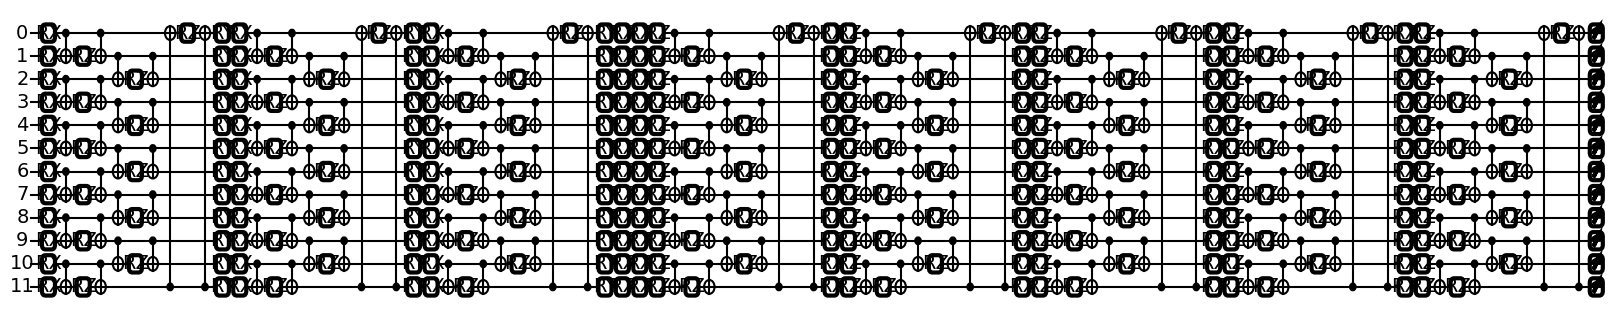

In [10]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(12)], np.zeros((n_layers, n_qubits, n_params)))
fig.set_size_inches((16,3))

In [11]:
weight_shapes = {"weights": (n_layers, n_qubits, n_params)}

In [12]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Hybrid model

In [13]:
input_dim = input_data.size(1)

layers =  [nn.Linear(input_dim*1, input_dim*2), nn.ReLU()]
layers += [nn.Linear(input_dim*2, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*3), nn.ReLU()] 
layers += [nn.Linear(input_dim*3, input_dim*2), nn.ReLU()] 
layers += [nn.Linear(input_dim*2, input_dim*1)] 
layers += [qlayer] 
layers += [nn.Linear(input_dim*1, input_dim*1)]
layers += [nn.Linear(input_dim*1, input_dim*1), nn.ReLU()] * 2 
layers += [nn.Linear(input_dim*1, 1          )] 
Net = nn.Sequential(*layers)

In [14]:
# Create an instance of the network
model = Net

In [15]:
import time

In [16]:
# time
start_time = time.time()


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
batch_size = 32

losses = []
losses_epochs = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):
        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()))

    losses_epochs.append(criterion(input_data, target_data).item())

    # Print the loss for this epoch
    # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


    # time
    # Compute elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert remaining time to hours, minutes, and seconds for better readability
    hours, remainder = divmod(estimated_remaining_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print the loss and remaining time for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Time remaining: ~{}h {}m {:.0f}s'.format(
        epoch+1, num_epochs, losses_epochs[-1], hours, minutes, seconds))


- Epoch [1/10], i: [0/9000], Loss: 14.7323
- Epoch [1/10], i: [32/9000], Loss: 21.9530
- Epoch [1/10], i: [64/9000], Loss: 15.5107
- Epoch [1/10], i: [96/9000], Loss: 17.3461
- Epoch [1/10], i: [128/9000], Loss: 12.7819
- Epoch [1/10], i: [160/9000], Loss: 17.1202
- Epoch [1/10], i: [192/9000], Loss: 13.8913
- Epoch [1/10], i: [224/9000], Loss: 5.8935
- Epoch [1/10], i: [256/9000], Loss: 8.2505
- Epoch [1/10], i: [288/9000], Loss: 9.6637
- Epoch [1/10], i: [320/9000], Loss: 11.3400
- Epoch [1/10], i: [352/9000], Loss: 10.0204
- Epoch [1/10], i: [384/9000], Loss: 12.0652
- Epoch [1/10], i: [416/9000], Loss: 4.5600
- Epoch [1/10], i: [448/9000], Loss: 8.5722
- Epoch [1/10], i: [480/9000], Loss: 5.4046
- Epoch [1/10], i: [512/9000], Loss: 6.0658
- Epoch [1/10], i: [544/9000], Loss: 9.2639
- Epoch [1/10], i: [576/9000], Loss: 7.5766
- Epoch [1/10], i: [608/9000], Loss: 5.4404
- Epoch [1/10], i: [640/9000], Loss: 8.1627
- Epoch [1/10], i: [672/9000], Loss: 6.0015
- Epoch [1/10], i: [704/900

d:\Raul\Programs\envs\PennyLane\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([9000, 1])) that is different to the input size (torch.Size([9000, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


- Epoch [2/10], i: [0/9000], Loss: 6.5590
- Epoch [2/10], i: [32/9000], Loss: 5.6422
- Epoch [2/10], i: [64/9000], Loss: 7.1969
- Epoch [2/10], i: [96/9000], Loss: 7.6744
- Epoch [2/10], i: [128/9000], Loss: 6.8401
- Epoch [2/10], i: [160/9000], Loss: 6.2074
- Epoch [2/10], i: [192/9000], Loss: 5.8552
- Epoch [2/10], i: [224/9000], Loss: 4.3676
- Epoch [2/10], i: [256/9000], Loss: 6.1434
- Epoch [2/10], i: [288/9000], Loss: 5.1759
- Epoch [2/10], i: [320/9000], Loss: 6.9956
- Epoch [2/10], i: [352/9000], Loss: 6.2967
- Epoch [2/10], i: [384/9000], Loss: 4.1824
- Epoch [2/10], i: [416/9000], Loss: 4.4476
- Epoch [2/10], i: [448/9000], Loss: 5.0692
- Epoch [2/10], i: [480/9000], Loss: 6.4664
- Epoch [2/10], i: [512/9000], Loss: 4.6630
- Epoch [2/10], i: [544/9000], Loss: 6.9810
- Epoch [2/10], i: [576/9000], Loss: 7.2517
- Epoch [2/10], i: [608/9000], Loss: 4.9228
- Epoch [2/10], i: [640/9000], Loss: 6.0283
- Epoch [2/10], i: [672/9000], Loss: 4.4512
- Epoch [2/10], i: [704/9000], Loss: 

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

NameError: name 'losses' is not defined

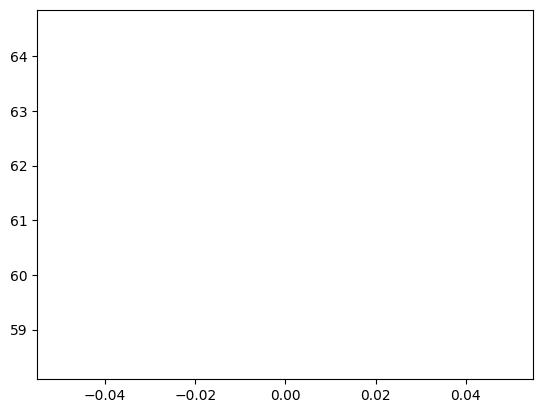

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [ ]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    loss = criterion(model(i), t)
    avg_loss += loss/len(target_validation)
    print('i: {}, target: {:.3f}, output: {:.3f}, loss: {:.3f}'.format(x, t.item(), model(i).item(), loss))
    print('')

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, target: 4.751, output: 0.000, loss: 22.574

i: 1, target: 7.348, output: 0.000, loss: 53.989

i: 2, target: 7.501, output: 0.000, loss: 56.262

i: 3, target: 3.801, output: 0.000, loss: 14.450

i: 4, target: 0.759, output: 0.000, loss: 0.575

i: 5, target: 3.659, output: 0.000, loss: 13.385

i: 6, target: 2.670, output: 0.000, loss: 7.127

i: 7, target: 5.412, output: 0.000, loss: 29.295

i: 8, target: 6.172, output: 0.000, loss: 38.098

i: 9, target: 6.088, output: 0.000, loss: 37.070

i: 10, target: 5.794, output: 0.000, loss: 33.576

i: 11, target: 4.941, output: 0.000, loss: 24.416

i: 12, target: 3.658, output: 0.000, loss: 13.380

i: 13, target: 3.883, output: 0.000, loss: 15.075

i: 14, target: 2.566, output: 0.000, loss: 6.582

i: 15, target: 5.410, output: 0.000, loss: 29.271

i: 16, target: 2.223, output: 0.000, loss: 4.942

i: 17, target: 3.735, output: 0.000, loss: 13.951

i: 18, target: 3.954, output: 0.000, loss: 15.633

i: 19, target: 4.084, output: 0.000, loss: 16

KeyboardInterrupt: 

# Save the Notebook as a PDF

In [ ]:
import subprocess
import os

name_notebook = "0724-hybrid_model.ipynb"  

output_filename = "results/"+ name_notebook[:4] +"/" + name_notebook[:-6] + "_0.pdf"

#check if the output file already exists
while os.path.exists(output_filename):
    print("The file {} already exists".format(output_filename))
    output_filename = output_filename[:-5] + str(int(output_filename[-5]) + 1) + ".pdf"
    print("Trying to save the file as {}".format(output_filename))
    

subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", output_filename, name_notebook])




The file results/0724/0724-classical_model_0.pdf already exists
Trying to save the file as results/0724/0724-classical_model_1.pdf
The file results/0724/0724-classical_model_1.pdf already exists
Trying to save the file as results/0724/0724-classical_model_2.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'results/0724/0724-classical_model_2.pdf', '0724-classical_model.ipynb'], returncode=0)